In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx

In [12]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 800
N_CHART = 800

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 30

# Maximum extension for chartists' timesteps window 
T_MAX = 15

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

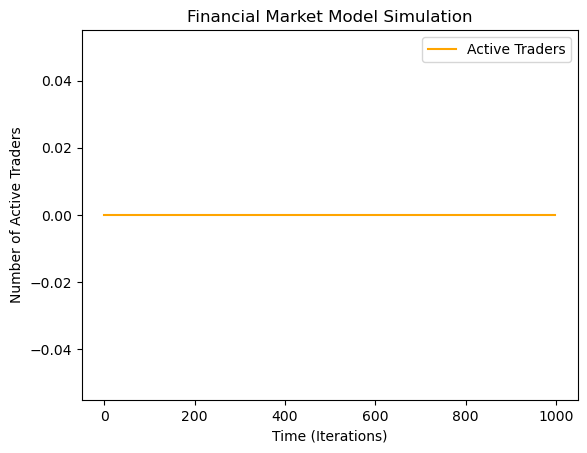

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D square lattice with open boundary conditions and an average degree <k>=4
size = int(np.sqrt(1600))  # Assuming N=1600, create a size*size network
Network_SW = nx.grid_2d_graph(size, size, periodic=False)

# Convert the 2D nodes into a list of indices for easy selection
nodes_indices = list(range(len(flat_nodes)))

# Add the edges to the network to mimic a Small World network
rewiring_prob = 0.02  # Probability for rewiring each edge
for edge in list(Network_SW.edges()):
    if np.random.rand() < rewiring_prob:
        Network_SW.remove_edge(*edge)
        # Randomly choose two new indices from the list of indices
        new_index1, new_index2 = np.random.choice(nodes_indices, 2, replace=False)
        # Map indices back to the actual node tuples
        new_edge = (flat_nodes[new_index1], flat_nodes[new_index2])
        # Add the new edge to the network if it doesn't create a self-loop or duplicate edge
        if new_edge[0] != new_edge[1] and not Network_SW.has_edge(*new_edge):
            Network_SW.add_edge(*new_edge)

# Initialize the information level Ii(t) for each agent
Ith = 1.0  # Threshold for all agents
informations = {node: np.random.uniform(0, Ith) for node in Network_SW.nodes()}

# Initialize the status of each trader (asker, bidder, holder)
statuses = {node: np.random.choice(['asker', 'bidder', 'holder']) for node in Network_SW.nodes()}

# Simulation parameters
alpha = 0.95  # Dissipation level of information
delta_I = 0.1  # Max increase of information at each time step
time_steps = 1000  # Number of time steps in the simulation

# Simulation execution loop
for t in range(time_steps):
    # Global informative pressure
    for node in Network_SW.nodes():
        informations[node] += np.random.uniform(0, max(0, Ith - informations[node]))

    # Herding mechanism
    for node in Network_SW.nodes():
        if informations[node] > Ith:
            statuses[node] = 'active'  # The trader becomes active
            informations[node] = 0  # Reset information
            neighbors = list(Network_SW.neighbors(node))
            # Spread the information to the neighbors
            for nn in neighbors:
                informations[nn] += alpha * informations[node] / len(neighbors)
                if informations[nn] > Ith and statuses[nn] != 'active':
                    statuses[nn] = 'active'  # Neighbor becomes active too

# Plotting
# For simplicity, let's just plot the number of active traders over time
active_counts = []
for t in range(time_steps):
    active_count = sum(status == 'active' for status in statuses.values())
    active_counts.append(active_count)
    # Reset the status for the next iteration
    for node in statuses:
        if statuses[node] == 'active':
            statuses[node] = np.random.choice(['asker', 'bidder', 'holder'])

plt.plot(active_counts, label='Active Traders', color='orange')
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Active Traders')
plt.legend()
plt.title('Financial Market Model Simulation')
plt.show()


In [ ]:
# 创建小世界网络
network = nx.watts_strogatz_graph(N, 4, 0.1)

# 初始化代理人属性
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('threshold', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = ('fund' if i < N_FUND else 'chart', W[i], M, Q, np.random.uniform(0, TAO), 'hold', np.random.uniform(0, Ith))

# 在模拟开始前初始化一个列表来存储每个时间步的活跃交易者数量
active_traders = []

# 模拟市场动态
for t in range(1, 100):  # 假设模拟100个时间步
    # 更新代理人状态和交易决策
    for i, agent in enumerate(agents):
        # 增加信息资产
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            agent['decision'] = np.random.choice(['buy', 'sell', 'hold'])
        else:  # 'chart'
            # Chartist agents buy if price is increasing, sell if decreasing
            agent['decision'] = np.random.choice(['buy', 'sell', 'hold'])

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        # Share decision information with neighbors
        for neighbor in neighbors:
            agents[neighbor]['decision'] = agent['decision']

            # 如果邻居的信息资产超过阈值，那么他们也变得活跃，并模仿决策
            if agents[neighbor]['info'] > Ith:
                agents[neighbor]['decision'] = agent['decision']

    # 计算活跃交易者数量（即决定买入或卖出的交易者数量）
    active_traders_count = sum(agent['decision'] in ['buy', 'sell'] for agent in agents)
    active_traders.append(active_traders_count)

# 在模拟结束后，创建一个图表来显示活跃交易者数量随时间的变化
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100), active_traders, marker='o')
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Active Traders')
plt.title('Number of Active Traders Over Time')
plt.grid(True)
plt.show()

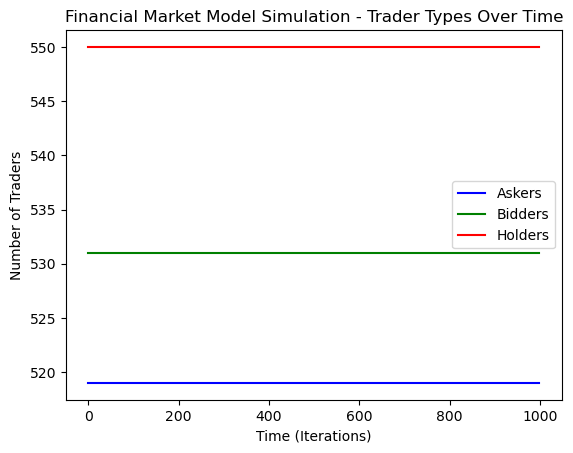

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D square lattice with open boundary conditions and an average degree <k>=4
size = int(np.sqrt(1600))  # Assuming N=1600, create a size*size network
Network_SW = nx.grid_2d_graph(size, size, periodic=False)

## Convert the 2D nodes into a list of indices for easy selection
nodes_indices = list(range(len(flat_nodes)))

# Add the edges to the network to mimic a Small World network
rewiring_prob = 0.02  # Probability for rewiring each edge
for edge in list(Network_SW.edges()):
    if np.random.rand() < rewiring_prob:
        Network_SW.remove_edge(*edge)
        # Randomly choose two new indices from the list of indices
        new_index1, new_index2 = np.random.choice(nodes_indices, 2, replace=False)
        # Map indices back to the actual node tuples
        new_edge = (flat_nodes[new_index1], flat_nodes[new_index2])
        # Add the new edge to the network if it doesn't create a self-loop or duplicate edge
        if new_edge[0] != new_edge[1] and not Network_SW.has_edge(*new_edge):
            Network_SW.add_edge(*new_edge)

# Initialize the information level Ii(t) for each agent
Ith = 1.0  # Threshold for all agents
informations = {node: np.random.uniform(0, Ith) for node in Network_SW.nodes()}

# Initialize the status of each trader (asker, bidder, holder)
statuses = {node: np.random.choice(['asker', 'bidder', 'holder']) for node in Network_SW.nodes()}

# Simulation parameters
alpha = 0.95  # Dissipation level of information
delta_I = 0.1  # Max increase of information at each time step
time_steps = 1000  # Number of time steps in the simulation

# Keep track of the number of 'asker', 'bidder', and 'holder' over time
asker_counts, bidder_counts, holder_counts = [], [], []

# Simulation execution loop
for t in range(time_steps):
    # Apply the global informative pressure and check if any trader exceeds the threshold
    for node in Network_SW.nodes():
        informations[node] += np.random.uniform(0, max(0, Ith - informations[node]))
        if informations[node] > Ith:
            # The trader becomes active and we record its current status
            active_status = statuses[node]
            informations[node] = 0  # Reset information
            # Spread the information to the neighbors
            neighbors = list(Network_SW.neighbors(node))
            for nn in neighbors:
                informations[nn] += alpha * informations[node] / len(neighbors)
                # If a neighbor exceeds the threshold, they adopt the status of the active trader
                if informations[nn] > Ith:
                    statuses[nn] = active_status
                    informations[nn] = 0  # Reset information after becoming active

    # Count the number of each type of trader after updates
    asker_count = sum(status == 'asker' for status in statuses.values())
    bidder_count = sum(status == 'bidder' for status in statuses.values())
    holder_count = sum(status == 'holder' for status in statuses.values())

    asker_counts.append(asker_count)
    bidder_counts.append(bidder_count)
    holder_counts.append(holder_count)

# Plotting
plt.plot(asker_counts, label='Askers', color='blue')
plt.plot(bidder_counts, label='Bidders', color='green')
plt.plot(holder_counts, label='Holders', color='red')
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Traders')
plt.legend()
plt.title('Financial Market Model Simulation - Trader Types Over Time')
plt.show()


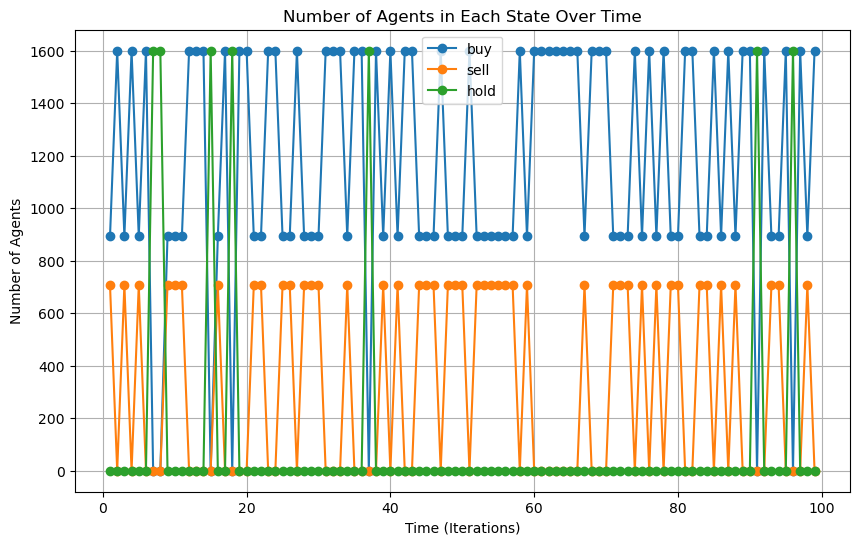

In [20]:
low_price = 10
high_price = 100
price_change_threshold = 0.05  # Price change threshold for holding

# Create a small-world network
network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('threshold', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(0, TAO), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize expected and actual price
expected_price = np.random.uniform(low_price, high_price)
actual_price = np.random.uniform(low_price, high_price)

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

        # Calculate price change
        price_change = abs(actual_price - expected_price) / expected_price

        if price_change < price_change_threshold:
            # If price change is within the threshold, hold
            agent['decision'] = 'hold'
        else:
            if agent['type'] == 'fund':
                # Fundamentalist agents buy if price is lower than expected price, sell if higher
                agent['decision'] = 'buy' if actual_price < expected_price else 'sell'
            else:  # 'chart'
                # Chartist agents buy if price is increasing, sell if decreasing
                agent['decision'] = 'buy' if actual_price > agent['info'] else 'sell'

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        # Share decision information with neighbors
        for neighbor in neighbors:
            agents[neighbor]['decision'] = agent['decision']

            # If the neighbor's information assets exceed the threshold, they also become active and imitate the decision
            if agents[neighbor]['info'] > Ith:
                agents[neighbor]['decision'] = agent['decision']

    # Calculate the number of agents in each state
    for state in ['buy', 'sell', 'hold']:
        state_counts[state].append(sum(agent['decision'] == state for agent in agents))

    # Update expected and actual price for the next time step
    expected_price = np.random.uniform(low_price, high_price)
    actual_price = np.random.uniform(low_price, high_price)

# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(1, 100), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

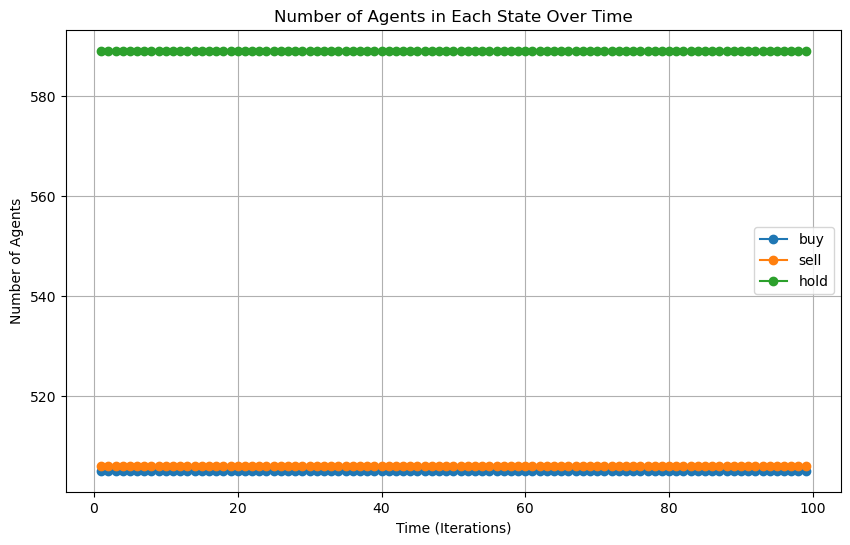

In [21]:


# Create a small-world network
network = nx.watts_strogatz_graph(N, 4, 0.02)
# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Set actual price
actual_price = 100
TAO = 20

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    # Update trading decisions of fundamentalist based on price
    for i, agent in enumerate(agents):
        if agent['type'] == 'fund':
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
                
    # global informative pressure coming from external sources
    for i, agent in enumerate(agents):
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))    
                
    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        ALPHA = 0.95  # 控制信息传播的衰减水平
        
        # 检查代理人的信息水平是否超过阈值
        
        if agent['info'] > Ith:
        # 代理人变得活跃，并向邻居传播交易状态
            for neighbor in neighbors:
                # 信息传递给邻居
                agents[neighbor]['info'] += alpha * agent['info'] / len(neighbors)
        
                # 如果邻居的信息超过阈值，那么他们也变得活跃，并模仿活跃代理人的决策
                if agents[neighbor]['info'] > Ith:
                    agents[neighbor]['decision'] = agent['decision']
                    agents[neighbor]['info'] = 0  # 重置信息水平

    # Calculate the number of agents in each state
    for state in ['buy', 'sell', 'hold']:
        state_counts[state].append(sum(agent['decision'] == state for agent in agents))

    # Update expected and actual price for the next time step
    expected_price = np.random.uniform(low=50, high=150)
    actual_price = 100

# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(1, 100), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()